# The Battle of the Neighbourhoods

### 1. Import the relevant libraries required for the project

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import requests
import random
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as mpatches

# !conda install -c conda-forge wordcloud==1.4.1 --yes
from wordcloud import WordCloud, get_single_color_func

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import (silhouette_samples, silhouette_score)
#!conda install -c conda-forge yellowbrick --yes
from yellowbrick.cluster import SilhouetteVisualizer

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import geocoder
import json

#!conda install -c conda-forge folium=0.5.0 
import folium
from folium.plugins import MiniMap

import wget

print('Libraries imported.')

Libraries imported.


### 2. Load the neighbourhoods data for both New York City and Toronto

1. Toronto Location Data:  [https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M ](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)
2. New York City Location Data: [https://geo.nyu.edu/catalog/nyu_2451_34572](https://geo.nyu.edu/catalog/nyu_2451_34572)

#### 2.1 Toronto Neighbourhoods Dataset

Scraping the neighbourhood data from a webpage

In [2]:
url_path = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
webPage = requests.get(url_path) 
html_code = webPage.text         
table_start = html_code.find('<table class="wikitable sortable">')     
table_end = html_code.find('</table>')    
toronto_data_table = html_code[table_start:table_end]         
toronto_df = pd.read_html(toronto_data_table, header = 0)[0]                                            
print("All table information has been scraped succesfully!")
toronto_df.head()

All table information has been scraped succesfully!


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [3]:
print(toronto_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 3 columns):
Postcode         287 non-null object
Borough          287 non-null object
Neighbourhood    287 non-null object
dtypes: object(3)
memory usage: 6.8+ KB
None


###### Data processing and cleaning of the dataframe

Remove any rows with an unassigned Borough

In [4]:
for i in range(len(toronto_df)):    
    if "Not assigned" in toronto_df.loc[i, "Borough"]:
        toronto_df = toronto_df.drop([i], axis = 0)
    else:
        toronto_df = toronto_df
toronto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210 entries, 2 to 285
Data columns (total 3 columns):
Postcode         210 non-null object
Borough          210 non-null object
Neighbourhood    210 non-null object
dtypes: object(3)
memory usage: 6.6+ KB


Combine rows with more than one neighbourhood.

In [5]:
join_rows = toronto_df.groupby("Postcode")["Neighbourhood"].apply(lambda x: ", ".join(x))
toronto_df.drop_duplicates(["Postcode"],inplace = True)  
toronto_df1 = toronto_df.join(join_rows, on = "Postcode", lsuffix='_1')   
toronto_df1.drop(columns = ["Neighbourhood_1"], inplace = True)
toronto_df1.reset_index(drop = True, inplace = True)         
toronto_df1.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park


Replacing the name of unassigned neighbourhoods with their borough name

In [6]:
# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
count = 0
for i in range(len(toronto_df1)):    
    if (toronto_df1.loc[i, "Borough"] != "Not assigned") and (toronto_df1.loc[i, "Neighbourhood"] == "Not assigned"):
        print("Index : ", i)
        count = count + 1
        toronto_df1.loc[i, "Neighbourhood"] == toronto_df1.loc[i, "Borough"]
    else:
        count = count 
print("Total number of replacements: ", count)

Index :  5
Total number of replacements:  1


In [7]:
print("Data has been cleaned!.\nShape of dataframe: "+ str(toronto_df1.shape))

Data has been cleaned!.
Shape of dataframe: (103, 3)


Extract the relevant data (i.e. only Downtown Toronto) from the Toronto Neighbourhoods in a pandas dataframe

In [8]:
downtown_toronto_data = toronto_df1[toronto_df1['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
downtown_toronto_data.head()

,Postcode,Borough,Neighbourhood
0,M5A,Downtown Toronto,Harbourfront
1,M7A,Downtown Toronto,Queen's Park
2,M5B,Downtown Toronto,"Ryerson, Garden District"
3,M5C,Downtown Toronto,St. James Town
4,M5E,Downtown Toronto,Berczy Park


Due to the instability of the geocoder locator, we were unable to obtain all the lats and longs of each neighbourhood and hence, used the csv file. Obtain the geospatial coordinates via a csv file which is read into a dataframe and joined on to the neighbourhoods dataframe.

In [9]:
geospatial_df = pd.read_csv("http://cocl.us/Geospatial_data", index_col = 0)  
downtown_toronto_df = downtown_toronto_data.copy()
downtown_toronto_df = downtown_toronto_df.join(geospatial_df, on = "Postcode")                                
downtown_toronto_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
1,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
2,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


#### 2.2 New York City Neighbourhoods Dataset

In [10]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')
print('Loading data...')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
print('\n...data loaded succesfully!')

Data downloaded!
Loading data...

...data loaded succesfully!


'wget' is not recognized as an internal or external command,
operable program or batch file.


###### Data processing and cleaning of the dataframe

Then let's loop through the data and fill the dataframe one row at a time.

In [11]:
newyorkcity_df = pd.DataFrame(columns = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'])
for data in newyork_data['features']:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyorkcity_df = newyorkcity_df.append({'Borough': borough,
                                            'Neighbourhood': neighborhood_name,
                                            'Latitude': neighborhood_lat,
                                            'Longitude': neighborhood_lon}, ignore_index=True)

In [12]:
print("{} neighbourhoods found in New York city.".format(newyorkcity_df.shape[0]))

306 neighbourhoods found in New York city.


Extract the relevant data (i.e. only Manhattan) from the New York City Neighbourhoods in a pandas dataframe

In [13]:
manhattan_ny_df = newyorkcity_df[newyorkcity_df['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_ny_df.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


#### 2.3 Concaternation of the two neighbourhoods datasets

The Downtown Toronto dataframe and Manhattan dataframe will be combined into one datatframe for the clustering.

In [14]:
full_df = downtown_toronto_df.drop("Postcode",axis = 1)
full_df = full_df.append(manhattan_ny_df, True).reset_index(drop = True)
pd.set_option('max_rows', 6)
full_df

,Borough,Neighbourhood,Latitude,Longitude
0,Downtown Toronto,Harbourfront,43.654260,-79.360636
1,Downtown Toronto,Queen's Park,43.662301,-79.389494
2,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
...,...,...,...,...
56,Manhattan,Stuyvesant Town,40.731000,-73.974052
57,Manhattan,Flatiron,40.739673,-73.990947
58,Manhattan,Hudson Yards,40.756658,-74.000111


### 3. Data Visualization

#### Create a map of the Toronto with Downtown Toronto neighborhoods superimposed on top.

For illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Downtown Toronto. So let's slice the original dataframe and create a new dataframe of the Downtown Toronto data.

Let's get the geographical coordinates of Downtown Toronto.

In [16]:
address = "Downtown Toronto, Toronto"
address1 = "Toronto, ON"
geolocator = Nominatim(user_agent = "toronto_explorer")
location = geolocator.geocode(address)
location1 = geolocator.geocode(address1)
downtown_toronto_latitude = location.latitude
downtown_toronto_longitude = location.longitude
toronto_latitude = location1.latitude
toronto_longitude = location1.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(toronto_latitude, toronto_longitude))
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(downtown_toronto_latitude, downtown_toronto_longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.
The geograpical coordinate of Downtown Toronto are 43.6541737, -79.38081164513409.


In [17]:
# Create map of Toronto centred around Downtown Toronto's latitude and longitude values
map_downtown_toronto = folium.Map(location = [downtown_toronto_latitude, downtown_toronto_longitude], zoom_start = 13)

# Add markers to map
for lat, lng, label in zip(downtown_toronto_df['Latitude'], downtown_toronto_df['Longitude'], downtown_toronto_df['Neighbourhood']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_downtown_toronto)  
    
tiny_map1 = MiniMap(position = 'bottomright',  center_fixed = (toronto_latitude, toronto_longitude), zoom_level_fixed = 8)
tiny_map1.add_to(map_downtown_toronto)
    
map_downtown_toronto
map_downtown_toronto.save('map_downtown_toronto_neighbourhoods.html')

#### Create a map of the New York City with Manhattan neighbourhoods superimposed on top.

Let's get the geographical coordinates of Manhattan.

In [18]:
address = "Manhattan, NY"
address1 = "New York City, NY"
geolocator = Nominatim(user_agent = "ny_explorer")
location = geolocator.geocode(address)
location1 = geolocator.geocode(address1)
manahattan_ny_latitude = location.latitude
manahattan_ny_longitude = location.longitude
ny_latitude = location1.latitude
ny_longitude = location1.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(ny_latitude, ny_longitude))
print('The geograpical coordinate of Manhattan are {}, {}.'.format(manahattan_ny_latitude, manahattan_ny_longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.
The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [19]:
# Create map of New York City using centered around Manhattan's latitude and longitude values
map_manhattan = folium.Map(location = [manahattan_ny_latitude, manahattan_ny_longitude], zoom_start = 12)

# Add markers to map
for lat, lng, borough, neighborhood in zip(manhattan_ny_df['Latitude'], manhattan_ny_df['Longitude'], manhattan_ny_df['Borough'], manhattan_ny_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cf330c',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_manhattan)  

tiny_map = MiniMap(position = 'bottomright',  center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
tiny_map.add_to(map_manhattan)

map_manhattan
map_manhattan.save('map_manhattan_neighbourhoods.html')

### 4. Data Exploration with Foursquare

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### 4.1 Define Foursquare Credentials and Version

In [20]:
CLIENT_ID = '2R3A5APBADS3FOQT523SAWNFIXL33TQXZS3JWDASG2HVK4XH' # your Foursquare ID
CLIENT_SECRET = 'ADLB4FMMXABMCEZPKSWD4P2ZNDFDCVEXVU3S21MO0QPQVHI3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

# print('Your credentails:')
# print('CLIENT_ID: ' + CLIENT_ID)
# print('CLIENT_SECRET:' + CLIENT_SECRET)

#### 4.2 Create and send a GET request

First, let's create the GET request and examine the results.

https://api.foursquare.com/v2/venues/explore?client_id=CLIENT_ID&client_secret=CLIENT_SECRET&ll=LATITUDE,LONGITUDE&v=VERSION&radius=500&limit=LIMIT

Send the GET request and examine the results

In [21]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def getNearbyVenues(names, boroughs, latitudes, longitudes, radius = 500, LIMIT = 100):
    ind = 1
    venues_list=[]
    for name, borough, lat, lng in zip(names, boroughs, latitudes, longitudes):
        tmp=[]
        print(color.BOLD+str(ind)+" | "+name+color.END) 
        ind += 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                             'Borough',
                             'Neighbourhood Latitude', 
                             'Neighbourhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

Now, let's get the top 100 venues that are within a radius 500m radius of each neighbourhood.

In [23]:
downtown_toronto_manhattan_venues = getNearbyVenues(names = full_df['Neighbourhood'],
                                                    boroughs = full_df['Borough'],
                                                    latitudes = full_df['Latitude'],
                                                    longitudes = full_df['Longitude']
                                                    )

1 | Harbourfront
2 | Queen's Park
3 | Ryerson, Garden District
4 | St. James Town
5 | Berczy Park
6 | Central Bay Street
7 | Christie
8 | Adelaide, King, Richmond
9 | Harbourfront East, Toronto Islands, Union Station
10 | Design Exchange, Toronto Dominion Centre
11 | Commerce Court, Victoria Hotel
12 | Harbord, University of Toronto
13 | Chinatown, Grange Park, Kensington Market
14 | CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
15 | Rosedale
16 | Stn A PO Boxes 25 The Esplanade
17 | Cabbagetown, St. James Town
18 | First Canadian Place, Underground city
19 | Church and Wellesley
20 | Marble Hill
21 | Chinatown
22 | Washington Heights
23 | Inwood
24 | Hamilton Heights
25 | Manhattanville
26 | Central Harlem
27 | East Harlem
28 | Upper East Side
29 | Yorkville
30 | Lenox Hill
31 | Roosevelt Island
32 | Upper West Side
33 | Lincoln Square
34 | Clinton
35 | Midtown
36 | Murray Hill
37 | Chelsea
38 | Greenwich Village
39 | East V

Let's check the size of the resulting dataframe

In [24]:
print(downtown_toronto_manhattan_venues.shape)
downtown_toronto_manhattan_venues.head()

(4634, 8)


,Neighbourhood,Borough,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,Downtown Toronto,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,Downtown Toronto,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,Downtown Toronto,43.65426,-79.360636,Cooper Koo Family YMCA,43.653191,-79.357947,Gym / Fitness Center
3,Harbourfront,Downtown Toronto,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Harbourfront,Downtown Toronto,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


Let's check how many venues were returned for each neighborhood

In [25]:
downtown_toronto_manhattan_venues.groupby('Neighbourhood').count()

,Borough,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100,100
Battery Park City,98,98,98,98,98,98,98
Berczy Park,57,57,57,57,57,57,57
...,...,...,...,...,...,...,...
Washington Heights,91,91,91,91,91,91,91
West Village,100,100,100,100,100,100,100
Yorkville,100,100,100,100,100,100,100


#### 4.3 Analyze Each Neighborhood - One Hot Encoding

In [26]:
# One hot encoding
downtown_toronto_manhattan_onehot = pd.get_dummies(downtown_toronto_manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighbourhood, borough, neighbouhood latitude and neighbourhood longitude columns back to dataframe
downtown_toronto_manhattan_onehot['Neighbourhood'] = downtown_toronto_manhattan_venues['Neighbourhood']  
downtown_toronto_manhattan_onehot['Borough'] = downtown_toronto_manhattan_venues['Borough']
downtown_toronto_manhattan_onehot['Neighbourhood Latitude'] = downtown_toronto_manhattan_venues['Neighbourhood Latitude']
downtown_toronto_manhattan_onehot['Neighbourhood Longitude'] = downtown_toronto_manhattan_venues['Neighbourhood Longitude']

# Move neighbourhood column to the first column
fixed_columns = [downtown_toronto_manhattan_onehot.columns[-1]] + list(downtown_toronto_manhattan_onehot.columns[:-1])
downtown_toronto_manhattan_onehot = downtown_toronto_manhattan_onehot[fixed_columns]
fixed_columns = [downtown_toronto_manhattan_onehot.columns[-1]] + list(downtown_toronto_manhattan_onehot.columns[:-1])
downtown_toronto_manhattan_onehot = downtown_toronto_manhattan_onehot[fixed_columns]
fixed_columns = [downtown_toronto_manhattan_onehot.columns[-1]] + list(downtown_toronto_manhattan_onehot.columns[:-1])
downtown_toronto_manhattan_onehot = downtown_toronto_manhattan_onehot[fixed_columns]
fixed_columns = [downtown_toronto_manhattan_onehot.columns[-1]] + list(downtown_toronto_manhattan_onehot.columns[:-1])
downtown_toronto_manhattan_onehot = downtown_toronto_manhattan_onehot[fixed_columns]

downtown_toronto_manhattan_onehot.head()

,Neighbourhood,Borough,Neighbourhood Latitude,Neighbourhood Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Poo

And let's examine the new dataframe size.

In [27]:
downtown_toronto_manhattan_onehot.shape

(4634, 368)

Next, let's group rows by neighbourhood, borough, neighbourhood latitude and longitude and by taking the mean of the frequency of occurrence of each category

In [28]:
downtown_toronto_manhattan_grouped = downtown_toronto_manhattan_onehot.groupby(['Neighbourhood','Borough','Neighbourhood Latitude','Neighbourhood Longitude']).mean().reset_index()
downtown_toronto_manhattan_grouped

,Neighbourhood,Borough,Neighbourhood Latitude,Neighbourhood Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Poo

Let's confirm the new size

In [29]:
downtown_toronto_manhattan_grouped.shape

(59, 368)

### 5. Cluster Analysis

#### 5.1 Create a new dataframe for clustering

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

First, let's write a function to sort the venues in descending order.

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create a dataframe with out the borough, latitude and longitude
downtown_toronto_manhattan_grouped_new = downtown_toronto_manhattan_grouped.drop(["Borough", "Neighbourhood Latitude", "Neighbourhood Longitude"], axis = 1)

# create columns according to number of top venues
columns = ["Neighbourhood"]
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted['Neighbourhood'] = downtown_toronto_manhattan_grouped_new['Neighbourhood']

for ind in np.arange(downtown_toronto_manhattan_grouped_new.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(downtown_toronto_manhattan_grouped_new.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Bar,Thai Restaurant,Restaurant,Sushi Restaurant,Bakery,Vegetarian / Vegan Restaurant,Bookstore
1,Battery Park City,Park,Coffee Shop,Hotel,Gym,Memorial Site,Shopping Mall,Women's Store,Boat or Ferry,Pizza Place,Italian Restaurant
2,Berczy Park,Coffee Shop,Seafood Restaurant,Bakery,Café,Farmers Market,Cocktail Bar,Cheese Shop,Beer Bar,Steakhouse,French Restaurant
3,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Plane,Sculpture Garden,Coffee Shop,Harbor / Marina,Boat or Ferry,Bar,Airport Gate
4,"Cabbagetown, St. James Town",Coffee Shop,Park,Bakery,Café,Pizza Place,Restaurant,Italian Restaurant,Pub,Bank,Gastropub


#### 5.2 Clustering

Let's cluster our data over a range of k values to determine the appropriate value for k.

In [32]:
n = 11
# Set the range of cluster samples
K = range(1,n)
# The distortions for each k will help us determine the appropriate number of clusters in conjuction with the elbow method.
distortions = []
downtown_toronto_manhattan_grouped_clustering = downtown_toronto_manhattan_grouped.drop(['Neighbourhood','Borough','Neighbourhood Latitude','Neighbourhood Longitude'], 1)

for k in K:
    # Run K-Means clustering algorithm
    kmeansModel = KMeans(n_clusters = k, random_state = 0, init = 'random', n_init = 25)
    kmeansModel.fit(downtown_toronto_manhattan_grouped_clustering)
    distortions.append(kmeansModel.inertia_)

Plotting the distortions of K-Means to find the best "k"

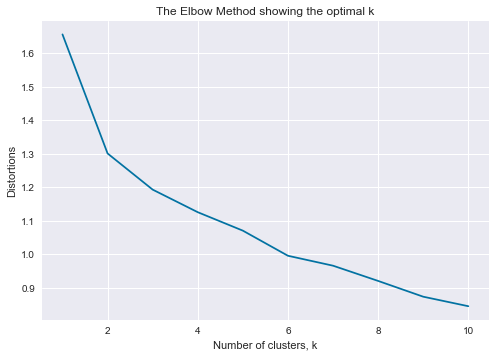

In [33]:
plt.style.use("seaborn")
plt.plot(K,distortions, 'bx-')
plt.xlabel("Number of clusters, k")
plt.ylabel("Distortions")
plt.title("The Elbow Method showing the optimal k")
plt.show()

The silhoutte score for finding the optimal number of clusters.
The silhouette coefficient of a data measures how well data are assigned to its own cluster and how far they are from other clusters.

For number of clusters K = 2 The average silhouette_score is : 0.6544043137589286


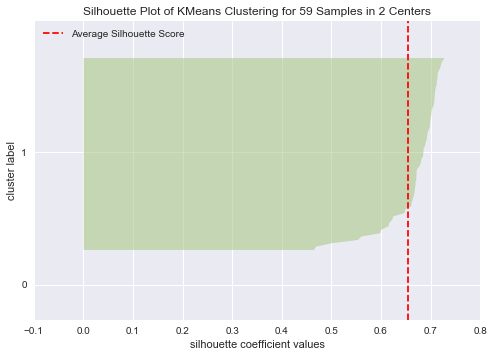

For number of clusters K = 3 The average silhouette_score is : 0.098649621525712


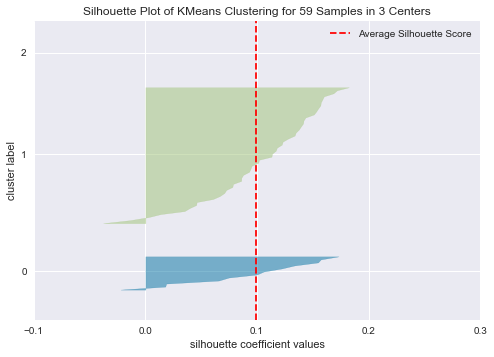

For number of clusters K = 4 The average silhouette_score is : 0.07040405215710166


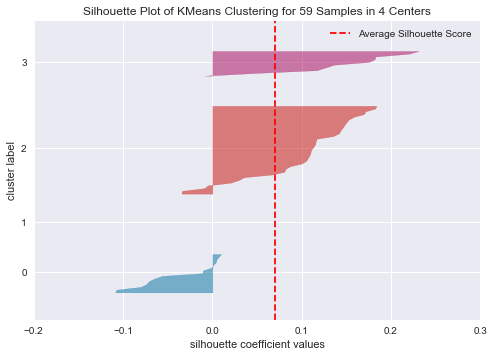

For number of clusters K = 5 The average silhouette_score is : 0.038394868846921386


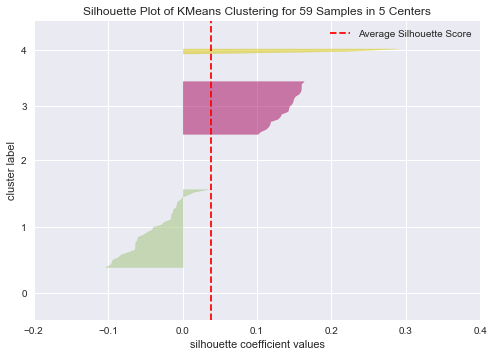

For number of clusters K = 6 The average silhouette_score is : 0.04507286420948848


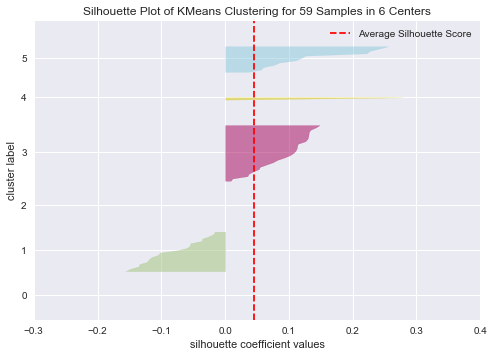

For number of clusters K = 7 The average silhouette_score is : 0.04432125415122786


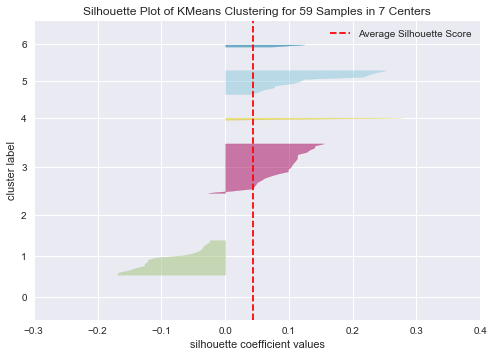

For number of clusters K = 8 The average silhouette_score is : 0.05495773861123154


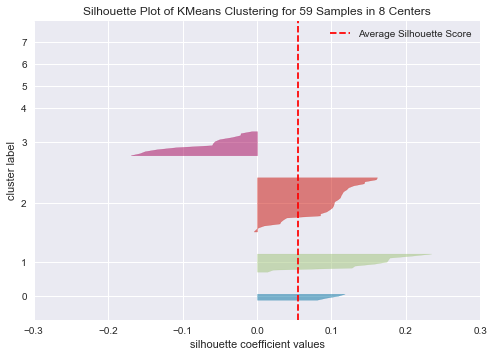

For number of clusters K = 9 The average silhouette_score is : 0.031090447905033156


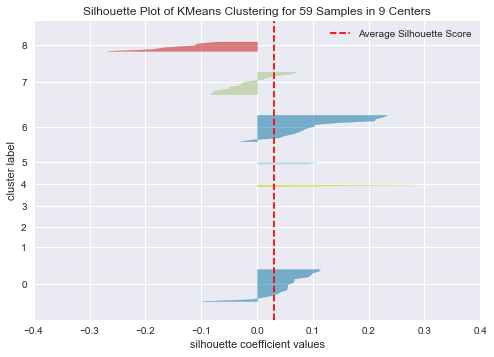

For number of clusters K = 10 The average silhouette_score is : 0.021515879404306493


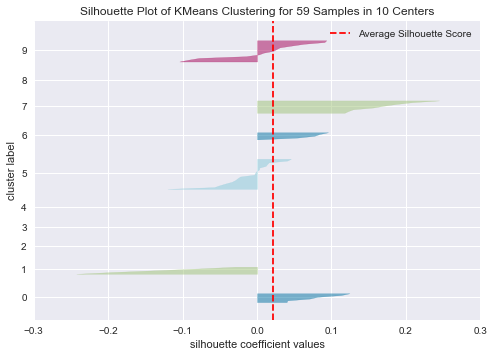

In [34]:
n = 11
# Set the range of cluster samples
K = range(2,n)
# The distortions for each k will help us determine the appropriate number of clusters in conjuction with the elbow method.
silhouette_values = []
downtown_toronto_manhattan_grouped_clustering = downtown_toronto_manhattan_grouped.drop(['Neighbourhood','Borough','Neighbourhood Latitude','Neighbourhood Longitude'], 1)

for k in K:
    # Run K-Means clustering algorithm
    kmeansModel = KMeans(n_clusters = k, random_state = 0, init = 'random', n_init = 25)
    kmeansModel.fit(downtown_toronto_manhattan_grouped_clustering)
    
    cluster_labels = kmeansModel.fit_predict(downtown_toronto_manhattan_grouped_clustering)
    silhouette_avg = silhouette_score(downtown_toronto_manhattan_grouped_clustering, cluster_labels)
    print("For number of clusters K =", k ,"The average silhouette_score is :", silhouette_avg)
    silhouette_values.append(silhouette_avg)
    
    # Visualize the silhouette coefficient display
    visualizer = SilhouetteVisualizer(kmeansModel, colors = "yellowbrick")
    visualizer.fit(downtown_toronto_manhattan_grouped_clustering)
    visualizer.show()

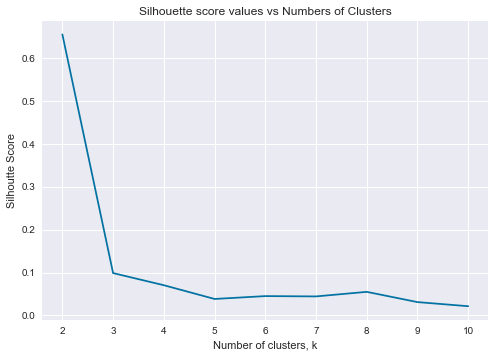

In [35]:
plt.style.use("seaborn")
plt.plot(K,silhouette_values, 'bx-')
plt.xlabel("Number of clusters, k")
plt.ylabel("Silhoutte Score")
plt.title("Silhouette score values vs Numbers of Clusters")
plt.show()

In [36]:
Optimal_NumberOf_Components = K[silhouette_values.index(max(silhouette_values))]
print("Optimal number of components is:", Optimal_NumberOf_Components)

Optimal number of components is: 2


#### 5.3 Cluster Neighborhoods with the best "k"

Run *K*-Means to cluster the neighborhood into 9 clusters as indicated by the elbow method.

In [37]:
# The best "k"
clusters_k = 2

# The dataframe used for clustering
downtown_toronto_manhattan_grouped_clustering = downtown_toronto_manhattan_grouped.drop(['Neighbourhood','Borough','Neighbourhood Latitude','Neighbourhood Longitude'], 1)

# Run the K-Means clustering algorithm with the best "k"
kmeansModel = KMeans(n_clusters = clusters_k, random_state = 0, init = 'random', n_init = 25)
kmeansModel.fit(downtown_toronto_manhattan_grouped_clustering)
cluster_labels = kmeansModel.fit_predict(downtown_toronto_manhattan_grouped_clustering)

In [38]:
# Add clustering labels
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeansModel.labels_)

downtown_toronto_manhattan_merged = full_df
downtown_toronto_manhattan_merged['Cluster Labels'] = kmeansModel.labels_
# Merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
# downtown_toronto_manhattan_merged = downtown_toronto_manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on = 'Neighbourhood')

downtown_toronto_manhattan_merged 

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels
0,Downtown Toronto,Harbourfront,43.654260,-79.360636,1
1,Downtown Toronto,Queen's Park,43.662301,-79.389494,1
2,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,1
...,...,...,...,...,...
56,Manhattan,Stuyvesant Town,40.731000,-73.974052,1
57,Manhattan,Flatiron,40.739673,-73.990947,1
58,Manhattan,Hudson Yards,40.756658,-74.000111,1


Finally, let's visualize the resulting clusters

In [39]:
# Create map
map_clusters = folium.Map(location = [downtown_toronto_latitude, downtown_toronto_longitude], zoom_start = 13)

# set color scheme for the clusters
x = np.arange(clusters_k)
ys = [i + x + (i*x)**2 for i in range(clusters_k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_toronto_manhattan_merged['Latitude'], downtown_toronto_manhattan_merged['Longitude'], downtown_toronto_manhattan_merged['Neighbourhood'], downtown_toronto_manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

tiny_map2 = MiniMap(position = 'bottomright',  center_fixed = (toronto_latitude, toronto_longitude), zoom_level_fixed = 8)
tiny_map2.add_to(map_clusters)
    
map_clusters
map_clusters.save('map_downtown_toronto_neighbourhoods_clusters.html')

In [40]:
# Create map of New York City using centered around Manhattan's latitude and longitude values
map_clusters1 = folium.Map(location = [manahattan_ny_latitude, manahattan_ny_longitude], zoom_start = 12)

# Add markers to map
for lat, lon, poi, cluster in zip(downtown_toronto_manhattan_merged['Latitude'], downtown_toronto_manhattan_merged['Longitude'], downtown_toronto_manhattan_merged['Neighbourhood'], downtown_toronto_manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.7).add_to(map_clusters1)  

tiny_map3 = MiniMap(position = 'bottomright',  center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
tiny_map3.add_to(map_clusters1)

map_clusters1
map_clusters1.save('map_manhattan_neighbourhoods_clusters.html')

#### 5.4  Examine Clusters

#### Cluster 1

In [41]:
pd.set_option('display.max_rows', 100)
cluster1 = downtown_toronto_manhattan_merged.loc[downtown_toronto_manhattan_merged['Cluster Labels'] == 0, downtown_toronto_manhattan_merged.columns[[1, 0] + list(range(5, downtown_toronto_manhattan_merged.shape[1]))]]
cluster1

,Neighbourhood,Borough
44,Manhattan Valley,Manhattan


#### Cluster 2

In [42]:
cluster2 = downtown_toronto_manhattan_merged.loc[downtown_toronto_manhattan_merged['Cluster Labels'] == 1, downtown_toronto_manhattan_merged.columns[[1, 0] + list(range(5, downtown_toronto_manhattan_merged.shape[1]))]]
cluster2

,Neighbourhood,Borough
0,Harbourfront,Downtown Toronto
1,Queen's Park,Downtown Toronto
2,"Ryerson, Garden District",Downtown Toronto
3,St. James Town,Downtown Toronto
4,Berczy Park,Downtown Toronto
5,Central Bay Street,Downtown Toronto
6,Christie,Downtown Toronto
7,"Adelaide, King, Richmond",Downtown Toronto
8,"Harbourfront East, Toronto Islands, Union Station",Downtown Toronto
9,"Design Exchange, Toronto Dominion Centre",Downtown Toronto


## 6. Discussion

We will create bar charts that will give us more insight into the clusters.

In [43]:
# Create a list with all 9 cluster labels
clusters_list = []
for k in range(1, (clusters_k+1)):
    cluster_label = "Cluster "+str(k)
    clusters_list.append(cluster_label)       
clusters_list

['Cluster 1', 'Cluster 2']

In [44]:
# downtown_toronto_manhattan_merged
# Create copy of the cluster dataframe.
downtown_toronto_manhattan_merged_copy = downtown_toronto_manhattan_merged.copy()

# Merge cluster1_merged with the top 10 venues in each neighbourhood in the cluster.
downtown_toronto_manhattan_merged_copy = downtown_toronto_manhattan_merged_copy.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on = 'Neighbourhood')

# Sort by cluster labels
downtown_toronto_manhattan_merged_copy.groupby(["Cluster Labels"]) 
downtown_toronto_manhattan_merged_copy = downtown_toronto_manhattan_merged_copy.sort_values(by = ["Cluster Labels"], axis = 0)
downtown_toronto_manhattan_merged_copy 

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Manhattan,Manhattan Valley,40.797307,-73.964286,0,Bar,Pizza Place,Indian Restaurant,Coffee Shop,Mexican Restaurant,Playground,Yoga Studio,Caribbean Restaurant,Chinese Restaurant,Deli / Bodega
0,Downtown Toronto,Harbourfront,43.654260,-79.360636,1,Coffee Shop,Bakery,Pub,Park,Café,Theater,Restaurant,Breakfast Spot,Mexican Restaurant,Spa
31,Manhattan,Upper West Side,40.787658,-73.977059,1,Italian Restaurant,Coffee Shop,Wine Bar,Bar,Café,Bakery,Indian Restaurant,Mediterranean Restaurant,Breakfast Spot,Seafood Restaurant
32,Manhattan,Lincoln Square,40.773529,-73.985338,1,Plaza,Concert Hall,Café,Theater,Italian Restaurant,Performing Arts Venue,American Restaurant,Park,Indie Movie Theater,Gym / Fitness Center
33,Manhattan,Clinton,40.759101,-73.996119,1,Theater,Gym / Fitness Center,Italian Restaurant,Spa,Coffee Shop,American Restaurant,Gym,Sandwich Place,Wine Shop,Hotel
34,Manhattan,Midtown,40.754691,-73.981669,1,Hotel,Clothing Store,Sporting Goods Shop,Coffee Shop,Café,Steakhouse,French Restaurant,Cocktail Bar,Bookstore,Bakery
35,Manhattan,Murray Hill,40.748303,-73.978332,1,Gym / Fitness Center,Japanese Restaurant,Sandwich Place,Coffee Shop,American Restaurant,Hotel,Italian Restaurant,Pub,Bar,Steakhouse
36,Manhattan,Chelsea,40.744035,-74.003116,1,Coffee Shop,Bakery,Italian Restaurant,Ice Cream Shop,Wine Shop,Theater,Art Gallery,Hotel,American Restaurant,Nightclub
37,Manhattan,Greenwich Village,40.726933,-73.999914,1,Italian Restaurant,Sushi Restaurant,Clothing Store,Café,Indian Restaurant,Seafood Restaurant,French Restaurant,Sandwich Place,Caribbean Restaurant,Chinese Restaurant
38,Manhattan,East Village,40.727847,-73.982226,1,Bar,Ice Cream Shop,Wine Bar,Chinese Restaurant,Pizza Place,Mexican Restaurant,Japanese Restaurant,Coffee Shop,Korean Restaurant,Ramen Restaurant


In [45]:
downtown_toronto_manhattan_merged_copy = downtown_toronto_manhattan_merged_copy.sort_values(by = ["Cluster Labels"], axis = 0)
downtown_toronto_manhattan_merged_copy1 = downtown_toronto_manhattan_merged_copy[[ '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue']].transpose()
# downtown_toronto_manhattan_merged_copy2 = downtown_toronto_manhattan_merged_copy.unique
downtown_toronto_manhattan_merged_copy

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Manhattan,Manhattan Valley,40.797307,-73.964286,0,Bar,Pizza Place,Indian Restaurant,Coffee Shop,Mexican Restaurant,Playground,Yoga Studio,Caribbean Restaurant,Chinese Restaurant,Deli / Bodega
1,Downtown Toronto,Queen's Park,43.662301,-79.389494,1,Coffee Shop,Park,Gym,Yoga Studio,Theater,Sushi Restaurant,Arts & Crafts Store,Juice Bar,Seafood Restaurant,Japanese Restaurant
2,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,1,Coffee Shop,Clothing Store,Bakery,Café,Japanese Restaurant,Cosmetics Shop,Restaurant,Lingerie Store,Italian Restaurant,Fast Food Restaurant
3,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,Restaurant,Clothing Store,American Restaurant,Italian Restaurant,Breakfast Spot,Cosmetics Shop,Beer Bar,Hotel
4,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,Coffee Shop,Seafood Restaurant,Bakery,Café,Farmers Market,Cocktail Bar,Cheese Shop,Beer Bar,Steakhouse,French Restaurant
5,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1,Coffee Shop,Italian Restaurant,Juice Bar,Burger Joint,Sandwich Place,Japanese Restaurant,Chinese Restaurant,Dessert Shop,Thai Restaurant,Department Store
6,Downtown Toronto,Christie,43.669542,-79.422564,1,Grocery Store,Café,Park,Coffee Shop,Restaurant,Baby Store,Candy Store,Athletics & Sports,Diner,Italian Restaurant
7,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,1,Coffee Shop,Café,Steakhouse,Bar,Thai Restaurant,Restaurant,Sushi Restaurant,Bakery,Vegetarian / Vegan Restaurant,Bookstore
8,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,1,Coffee Shop,Aquarium,Hotel,Italian Restaurant,Café,Scenic Lookout,Brewery,Fried Chicken Joint,Restaurant,Bar
9,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,1,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Bakery,Bar,Seafood Restaurant,Gastropub,Steakhouse


In [50]:
clusters_data = np.zeros((kmeansModel.cluster_centers_.shape))
clusters_data[0,:] = kmeansModel.cluster_centers_[0,:]
clusters_data[1,:] = kmeansModel.cluster_centers_[1,:]
maxi = []
for i in range(2):
    maxi.extend(clusters_data[i,:].argsort()[-9:][::-1])
    
args = np.asarray(list(set(maxi)))
new_df = pd.DataFrame(data = clusters_data[:,args.astype(int)], index = clusters_list, columns = downtown_toronto_manhattan_grouped_clustering.columns[args.astype(int)])
new_df = new_df.transpose()
new_df

,Cluster 1,Cluster 2
Eastern European Restaurant,0.00,0.000831
Pizza Place,0.00,0.020191
Playground,0.25,0.004814
American Restaurant,0.00,0.020115
Coffee Shop,0.00,0.060292
Doctor's Office,0.00,0.000172
Dog Run,0.00,0.003465
Doner Restaurant,0.00,0.000205
Donut Shop,0.00,0.002613
Drugstore,0.00,0.000172


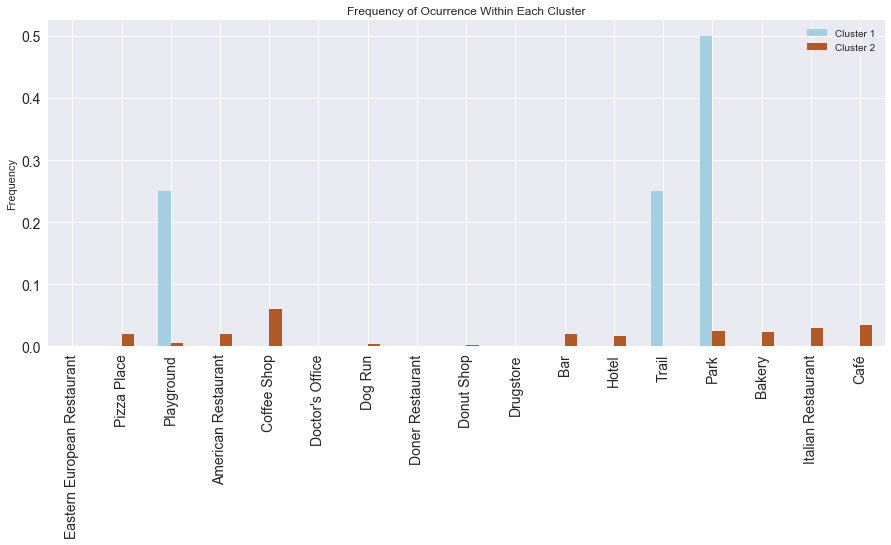

In [51]:
plt.style.use('seaborn')
ax = new_df.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = 'Paired')
bars = ax.get_children()
plt.title("Frequency of Ocurrence Within Each Cluster")
plt.ylabel("Frequency")

plt.show()